In [1]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/temp-sr-press


In [2]:
from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy import sb
from express.databases import SQLiteDatabase
from express.visualization import plot_action
from express.utils import add_names
import express.config as config

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
SBL = StatsBombLoader(root=os.path.join(base_path, "open-data/data"), getter="local")
competition = sb.competitions()

# HTTPError: 404 Client Error: Not Found for ur
Error_competition = [(11, 90), (7, 235), (7, 108), (44, 107)] # La-Liga 20/21, Ligue1 21/22, Ligue1 22/23 
competition = competition[~competition[["competition_id", "season_id"]].apply(tuple, axis=1).isin(Error_competition)] # HTTPError: 404 Client Error: Not Found for ur
competition = competition[(competition["match_available_360"].notna()) & (competition["competition_gender"] == "male")]
competition

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402


In [5]:
train_competition = competition[~(competition["competition_name"] == "FIFA World Cup")]
test_competition = competition[(competition["competition_name"] == "FIFA World Cup")]

print(train_competition.shape, test_competition.shape)

(3, 12) (1, 12)


In [6]:
train_games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in train_competition.itertuples()
]).reset_index(drop=True)

test_games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in test_competition.itertuples()
]).reset_index(drop=True)

print(train_games.shape, test_games.shape)
train_games

(136, 12) (64, 12)


,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3895302,281,9,Regular Season,29,2024-04-14 17:30:00,904,176,5,0,BayArena,Harm Osmers
1,3895292,281,9,Regular Season,28,2024-04-06 15:30:00,190,904,0,1,Stadion An der Alten Försterei,Benjamin Brand
2,3895333,281,9,Regular Season,32,2024-05-05 18:30:00,184,904,1,5,Deutsche Bank Park,Christian Dingert
3,3895340,281,9,Regular Season,33,2024-05-12 20:30:00,868,904,0,5,Vonovia Ruhrstadion,Benjamin Brand
4,3895348,281,9,Regular Season,34,2024-05-18 16:30:00,904,172,2,1,BayArena,Matthias Jöllenbeck
...,...,...,...,...,...,...,...,...,...,...,...,...
131,3788742,43,55,Group Stage,1,2021-06-12 18:00:00,776,1835,0,1,Parken,Anthony Taylor
132,3788775,43,55,Group Stage,3,2021-06-23 18:00:00,908,772,0,5,Estadio de La Cartuja,Björn Kuipers
133,3788776,43,55,Group Stage,3,2021-06-23 18:00:00,790,789,3,2,Saint-Petersburg Stadium,Michael Oliver
134,3788743,43,55,Group Stage,1,2021-06-12 21:00:00,782,796,3,0,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz


In [7]:
save_path = os.path.join(base_path, "stores")
if not os.path.exists(save_path):
    os.makedirs(save_path)

TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f13da659bb0>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f14342133d0>


In [8]:
for _, game in tqdm(train_games.iterrows(), desc="train_game loading"):
    dataset = {"getter": "remote", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"]}
    
    train_db.import_data(**dataset)

for _, game in tqdm(test_games.iterrows(), desc="test_game loading"):
    dataset = {"getter": "remote", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"]}
    
    test_db.import_data(**dataset)

train_game loading: 0it [00:00, ?it/s]

test_game loading: 0it [00:00, ?it/s]

In [12]:
game_id = 3788741

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head(3)

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3788741,0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,1,0.878,909,11086,52.0625,34.425,28.0000,...,From Kick Off,0,1.910504,"{'pass': {'recipient': {'id': 8963, 'name': 'C...","[[0.0, 44.39976078697438], [16.82907029647681,...",0,"[{'teammate': False, 'actor': False, 'keeper':...",pass,success,foot_right
1,3788741,1,bea4235d-7e40-461c-bb82-6d473f5bb324,1,2.789,909,8963,28.0000,43.945,31.2375,...,From Kick Off,0,1.499077,"{'carry': {'end_location': [36.2, 30.4]}}","[[30.27094296623723, 2.3520882891309185], [5.7...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot
2,3788741,2,84b9b798-0fbe-45bc-a4bf-3621959f29ce,1,4.288,909,8963,31.2375,42.585,61.4250,...,From Kick Off,0,2.476772,"{'pass': {'recipient': {'id': 8541, 'name': 'K...","[[31.00063614049526, 1.2150785249513518], [6.7...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left


904 176


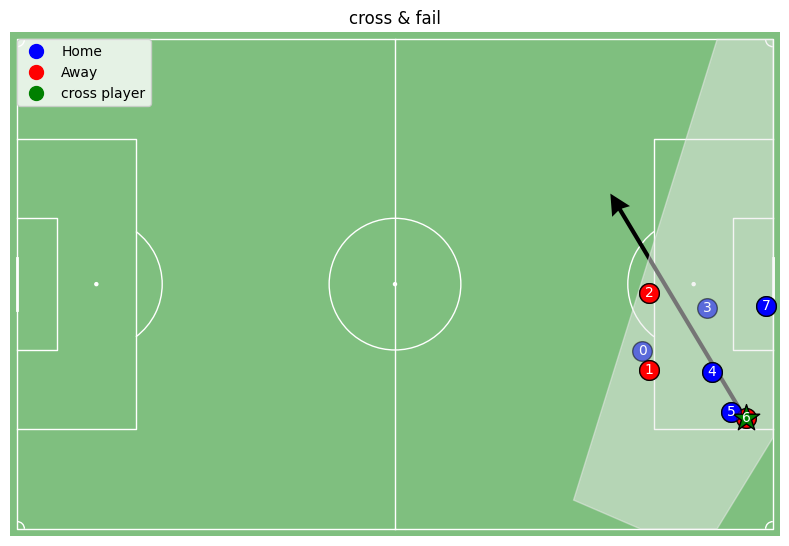

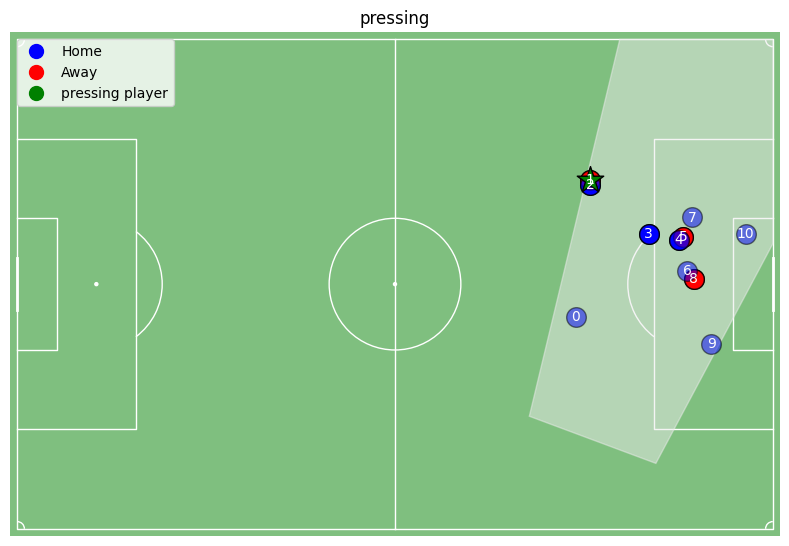

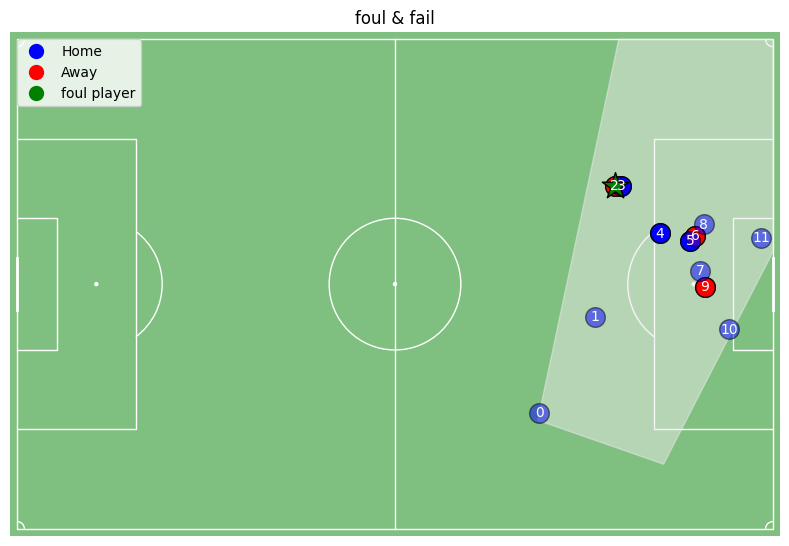

In [13]:
pressure_idx = df_actions[df_actions["original_event_id"] == "c7a944da-653b-4b91-9d68-c9e0dd1b5793"].index[0]#df_actions[df_actions["type_name"] == "pressing"].index[150]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3895302)

print(home_team_id, away_team_id)
#plot_action(df_actions.loc[pressure_idx], home_team_id=home_team_id)

for idx in range(pressure_idx-1, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)